In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2

In [ ]:
landmarks_frame = pd.read_csv('/content/drive/My Drive/3-1深度學習/期中/total_data.csv')

n = 0
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks)
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 5 Landmarks: {}'.format(landmarks[:5]))

Image name: Emma_Watson_000002_0.png
Landmarks shape: (5, 2)
First 5 Landmarks: [[ 81.  84.]
 [173.  87.]
 [118. 141.]
 [ 86. 158.]
 [167. 161.]]


In [ ]:
print('Number of images: ', landmarks.shape[0])

img2 = cv2.imread(r'/content/drive/My Drive/3-1深度學習/期中/Emma_Charlotte_Duerre_Watson/Emma_Watson_000002_0.png')
width, height, channels = img2.shape
npixel = img2.size
print("npixel", npixel)
print("width {}, height {}, channels {}".format(width, height, channels))

Number of images:  5
npixel 196608
width 256, height 256, channels 3


In [ ]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [ ]:
import torch

In [ ]:
from torch.utils.data import Dataset, DataLoader
class MyDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, train= True):
        im = pd.read_csv(csv_file)
        im_len = len(im)
        train_size = int(im_len*0.3) - (im_len%5)
        total_size=im_len

        f = im[:train_size+1]
        l = root_dir

        if train == True:
          f = im[train_size+5:total_size+1] #feature
          l = root_dir
          data_size = total_size - train_size
        self.landmarks_frame = f
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        self.train_size = train_size
    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if idx <= self.train_size:
          img_name = os.path.join(self.root_dir,
                                  self.landmarks_frame.iloc[idx, 0])
          image = io.imread(img_name)
          landmarks = self.landmarks_frame.iloc[idx, 1:]
          landmarks = np.array([landmarks])
        if self.train == True:
          if idx > self.train_size:
            img_name = os.path.join(self.root_dir,
                                  self.landmarks_frame.iloc[idx, 0])
            image = io.imread(img_name)
            landmarks = self.landmarks_frame.iloc[idx, 1:]
            landmarks = np.array([landmarks])

        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
# Construct the dataset
face_dataset = MyDataset(csv_file= '/content/drive/My Drive/3-1深度學習/期中/adjusted_total_data.csv',
                                      root_dir= '/content/drive/My Drive/3-1深度學習/期中/Emma_Charlotte_Duerre_Watson/', train=True)
face_dataset_test = MyDataset(csv_file= '/content/drive/My Drive/3-1深度學習/期中/adjusted_total_data.csv',
                                      root_dir= '/content/drive/My Drive/3-1深度學習/期中/Emma_Charlotte_Duerre_Watson/', train=False)

# print some stats about the dataset
print('Length of train dataset: ', len(landmarks_frame))
print('Length of train dataset: ', len(face_dataset))
print('Length of test dataset: ', len(face_dataset_test))

Length of train dataset:  6929
Length of train dataset:  4850
Length of test dataset:  2075


In [ ]:
def show_keypoints(image, key_pts):
    """Show image with keypoints"""
    plt.imshow(image)
    plt.scatter([key_pts[:, 0]], [key_pts[:, 1]], s=50, marker='x', c='r')

0 (256, 256, 3) (5, 2)
1 (256, 256, 3) (5, 2)
2 (256, 256, 3) (5, 2)


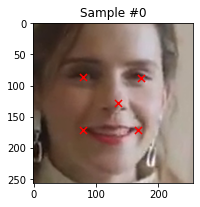

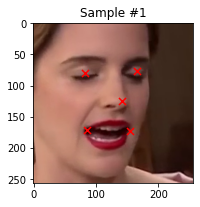

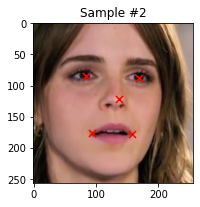

In [ ]:
num_to_display = 3

for i in range(num_to_display):

    # define the size of images
    fig = plt.figure(figsize=(20,10))

    # randomly select a sample
    rand_i = np.random.randint(0, len(face_dataset))
    sample = face_dataset[rand_i]

    # print the shape of the image and keypoints
    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(num_to_display,1, i + 1)
    ax.set_title('Sample #{}'.format(i))

    # Using the same display function, defined earlier
    show_keypoints(sample['image'], sample['landmarks'])
plt.show()

In [ ]:
from torchvision import transforms, utils
# tranforms
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        image = cv2.resize(image, (new_w, new_h))

        # scale the pts, too
        # landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': image, 'landmarks': landmarks}

In [ ]:
class ToTensor(object):
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = image.transpose((2, 0, 1))

        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [ ]:
train_dataset = MyDataset(csv_file='/content/drive/My Drive/3-1深度學習/期中/adjusted_total_data.csv',
                                     root_dir='/content/drive/My Drive/3-1深度學習/期中/Emma_Charlotte_Duerre_Watson/',
                                     transform=transforms.Compose([Rescale(64),
                                                                   ToTensor()]),
                                     train = True)
test_dataset = MyDataset(csv_file='/content/drive/My Drive/3-1深度學習/期中/adjusted_total_data.csv',
                                    root_dir='/content/drive/My Drive/3-1深度學習/期中/Emma_Charlotte_Duerre_Watson/',
                                    transform=transforms.Compose([Rescale(64),
                                                                  ToTensor()]),
                                    train = False)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=5,
                        shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=5,
                        shuffle=False)

In [ ]:
import torch.nn as nn

In [ ]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(stride=2,kernel_size=2)
    )
    self.dense = nn.Sequential(
        nn.Linear(32*32*512,1024),
        nn.ReLU(),
        nn.Linear(1024,512),
        nn.ReLU(),
        nn.Linear(512,10)
    )
  def forward(self,x):
    out=self.conv(x)
    out=out.view(-1,32*32*512)
    out=self.dense(out)
    return out

In [ ]:
model = Model()


In [ ]:
print(model)

Model(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Linear(in_features=524288, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [ ]:
num_epoch = 50

learning_rate = 0.001

In [ ]:
import torch.optim as opt

In [ ]:
loss_fn = nn.MSELoss()
optimizer = opt.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from torch.autograd import Variable

In [ ]:
for epoch in range(num_epoch):
  for i, sample in enumerate(train_loader):
    images = Variable(sample['image'].type(torch.cuda.FloatTensor)) #做reshape
    labels = sample['landmarks'].view(sample['landmarks'].size(0), -1)
    labels = Variable(labels.type(torch.cuda.FloatTensor))
    optimizer.zero_grad() #將gradient歸零
    outputs = model(images)
    loss = loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
    if (i+1)%100 == 0:
      print("Epoch:%d, Batch:%d, Loss:%.4f" %(epoch+1, i+1, loss.data))

In [ ]:
def visualize_output(test_images, test_outputs, gt_pts=None):
    plt.figure(figsize=(20,10))
    for i in range(len(test_outputs)):
        n = test_images*5
        ax = plt.subplot(len(test_outputs)//5,5 , i+1)
        name = os.path.join('/content/drive/My Drive/3-1深度學習/期中/Emma_Charlotte_Duerre_Watson/',landmarks_frame.iloc[i+n, 0])
        Image = io.imread(name)

        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()

        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]

        show_all_keypoints(Image, predicted_key_pts, ground_truth_pts)

        plt.axis('off')

    plt.show()

In [ ]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""


    plt.imshow(image)
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=50, marker='x', c='m')
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=30, marker='o', c='g')

In [ ]:
# torch.save(model,r'/content/drive/My Drive/3-1深度學習/期中/model86_50e_64_5_3.pkl')

In [ ]:
m = torch.load(r'/content/drive/My Drive/3-1深度學習/期中/model86_50e_64_5_3.pkl')

In [ ]:
landmarks_frame = pd.read_csv('/content/drive/My Drive/3-1深度學習/期中/adjusted_total_data.csv')

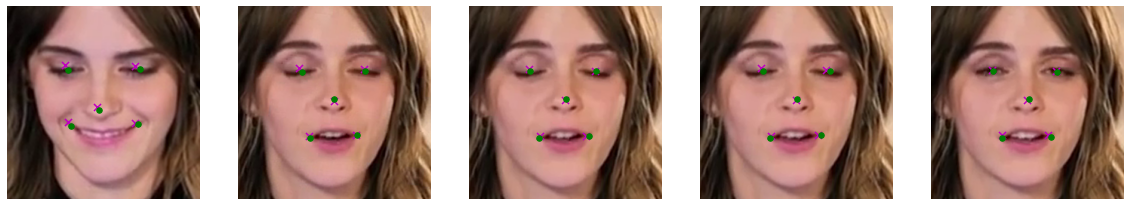

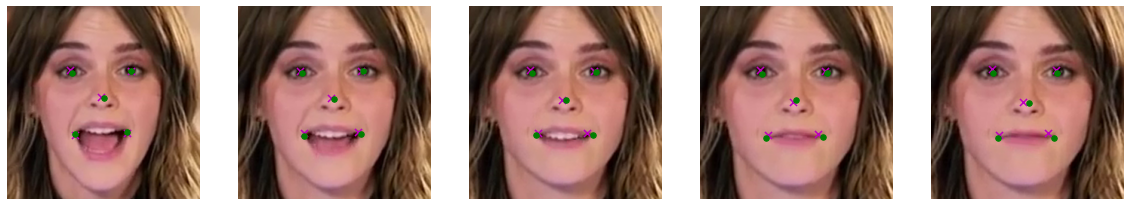

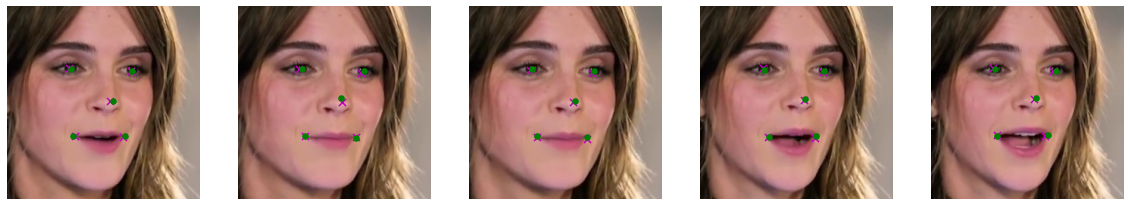

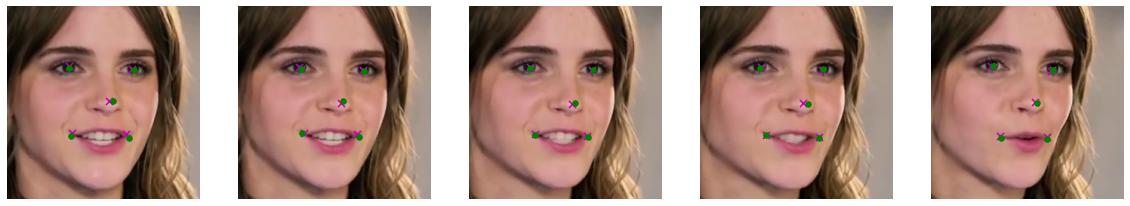

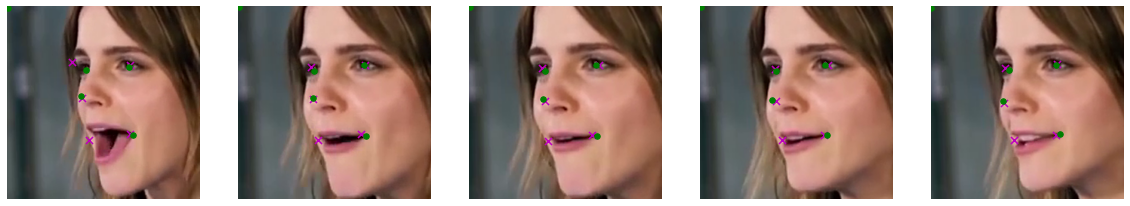

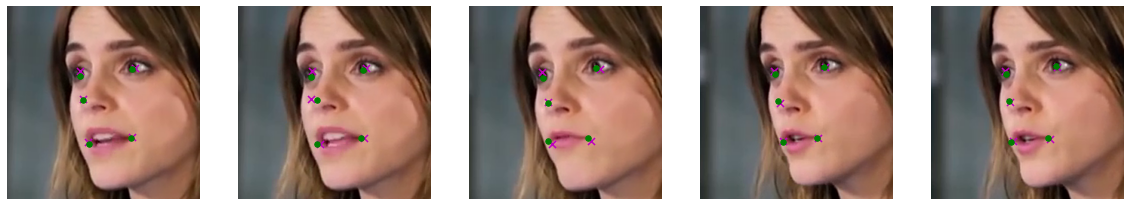

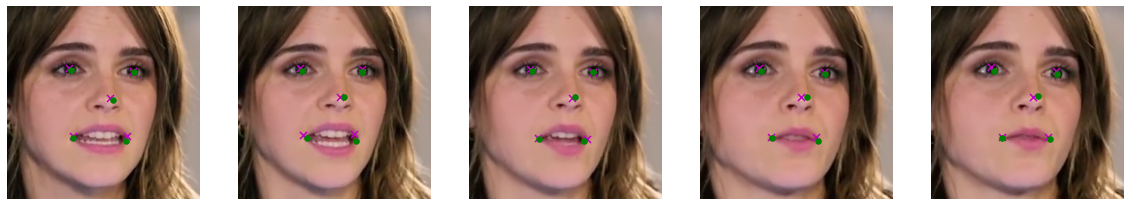

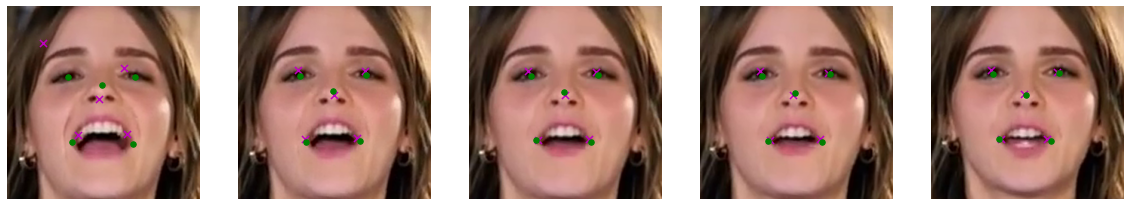

Accuracy: 86.0240963855%


In [ ]:
correct=0
total=0
count = 0
root = '/content/drive/My Drive/3-1深度學習/期中/Emma_Charlotte_Duerre_Watson/'
for i,sample in enumerate(test_loader):
  images=Variable(sample['image'].type(torch.cuda.FloatTensor)) #攤平
  outputs=m(images)
#  _,pred=torch.max(outputs.data,1)
  pred=outputs.view(outputs.size()[0],5,-1)
  labels=sample['landmarks']
  labels=labels.view(outputs.size()[0],5,-1)
  check = Variable(labels.type(torch.cuda.FloatTensor))


  a = torch.sqrt(torch.sum((pred-check)**2, dim=2))#算距離
  b = torch.max(a, dim = 1)#找出最每張圖的最大距離值
  if (count+1)%50 == 0:
    visualize_output(i, pred, labels)
  count += 1
  c = torch.le(b.values,10.5)#比較最大距離 <=6.5 (會回傳true false)
  correct += torch.sum(c)#加總每次batch的True值
  total += labels.size(0)
  #print(labels.size(0))
print('Accuracy: %.10f%%' %(100*float(correct)/float(total)))


In [ ]:
from torch.utils.data import Dataset, DataLoader
class TestDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, ranlist, transform=None):
        im = pd.read_csv(csv_file)
        irand = ranlist
        self.landmarks_frame = im
        self.root_dir = root_dir
        self.transform = transform
        self.irand = irand
    def __len__(self):
        return len(self.irand)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        num = self.irand[idx]
        name = os.path.join(self.root_dir,self.landmarks_frame.iloc[num, 0])
        Image = io.imread(name)
        Landmarks = self.landmarks_frame.iloc[num, 1:]
        Landmarks = np.array([Landmarks])

        Landmarks = Landmarks.astype('float').reshape(-1, 2)
        sample = {'image': Image, 'landmarks': Landmarks}

        if self.transform:
          sample = self.transform(sample)

        return sample

In [ ]:
irand=np.random.choice(2075,40)
Test = TestDataset(csv_file='/content/drive/My Drive/3-1深度學習/期中/adjusted_total_data.csv',
                   root_dir='/content/drive/My Drive/3-1深度學習/期中/Emma_Charlotte_Duerre_Watson/',
                   ranlist= irand,
                   transform=transforms.Compose([Rescale(64),ToTensor()]))

In [ ]:
TestLoader = DataLoader(Test, batch_size=5,
                        shuffle=False)

In [ ]:
def visualize_predict(test_images, test_outputs, irand, gt_pts=None):
    plt.figure(figsize=(20,10))
    for i in range(len(test_outputs)):
        n = irand[test_images*5 + i]
        ax = plt.subplot(len(test_outputs)//5,5 , i+1)
        name = os.path.join('/content/drive/My Drive/3-1深度學習/期中/Emma_Charlotte_Duerre_Watson/',landmarks_frame.iloc[n, 0])
        Image = io.imread(name)

        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.cpu().numpy()

        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]

        show_all_keypoints(Image, predicted_key_pts, ground_truth_pts)

        plt.axis('off')

    plt.show()

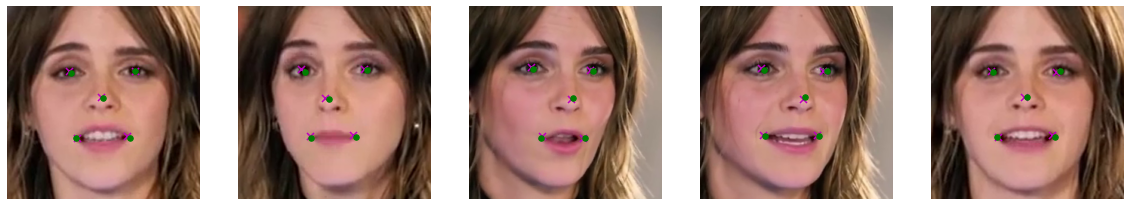

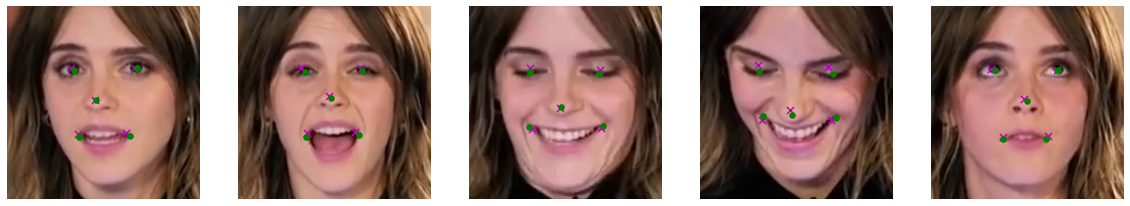

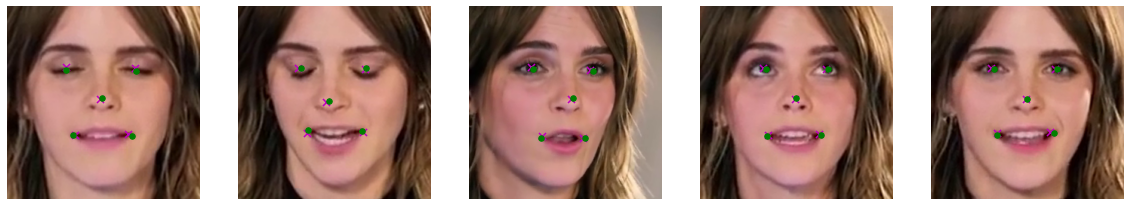

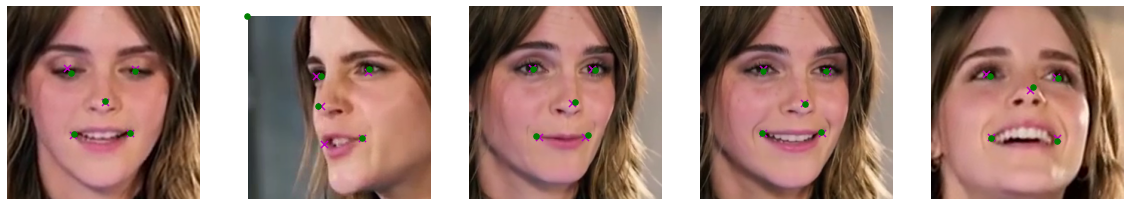

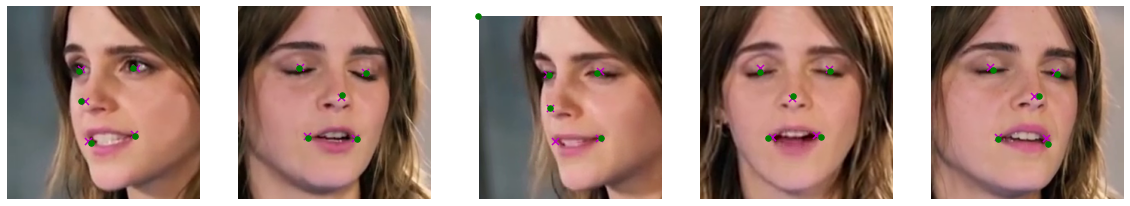

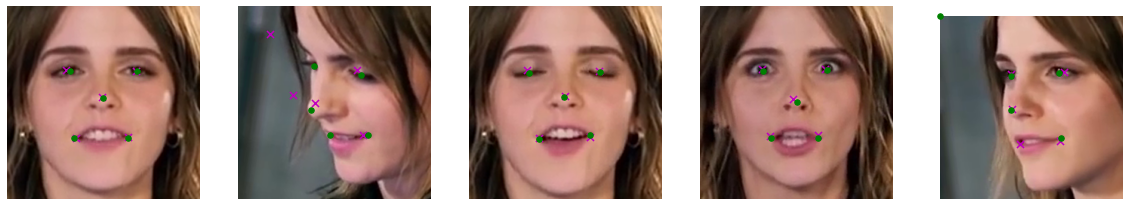

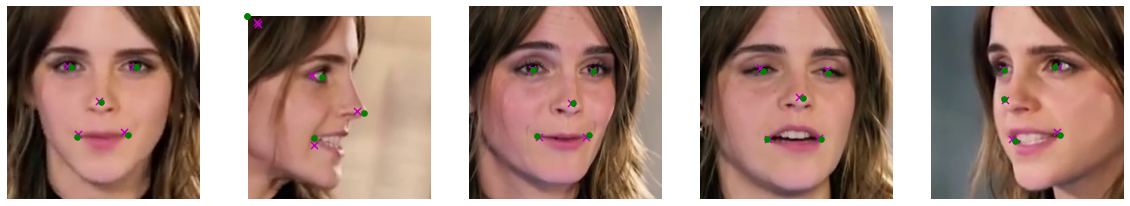

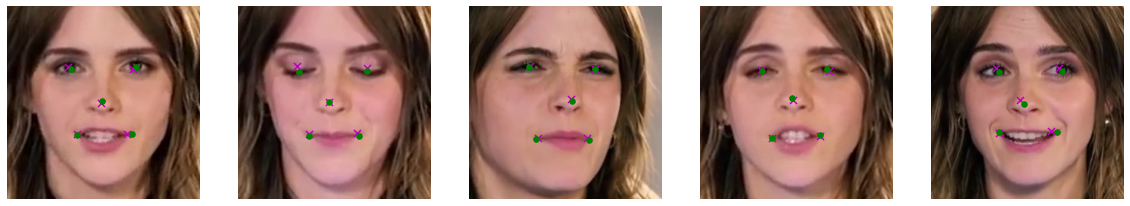

In [ ]:
for i,sample in enumerate(TestLoader):
  images=Variable(sample['image'].type(torch.cuda.FloatTensor)) #攤平
  outputs=m(images)
  pred=outputs.view(outputs.size()[0],5,-1)
  labels=sample['landmarks']
  visualize_predict(i, pred, irand, labels)